<div class="alert alert-block alert-info">

- [Import the needed libraries](#2nd-bullet)<br>
- [Import the dataset](#3rd-bullet)<br>
    
- [Filter methods](#6th-bullet)<br>
    - [Univariate variables](#7th-bullet)<br>
    - [Correlation Indices](#8th-bullet)<br>
    - [Chi-Square](#9th-bullet)<br>
- [Wrapper Methods](#10th-bullet)<br>
    - [RFE](#11th-bullet)<br>
        - [RFE Logistic Reg.](#12th-bullet)<br>
        - [RFE XGBoostClassifier.](#12th-bullet)<br>
- [Embedded Methods](#13th-bullet)<br>
    - [Lasso](#14th-bullet)<br>
- [Final Insights](#15th-bullet)<br>
    
</div>

# Chiel make the threshold between 0 and 0.2 dor correlation matrixes

<a class="anchor" id="2nd-bullet">

### Import the needed libraries
    
</a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # setting seaborn default for plots

# data partition
from sklearn.model_selection import train_test_split


#filter methods
# spearman
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, RFECV
from xgboost import XGBClassifier

# embedded methods
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest  # mutual information is a embedded method for regression problems

# model assessment
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')


<a class="anchor" id="3rd-bullet">

### Import the dataset
    
</a>

In [30]:
preproc_train = pd.read_csv('../data/traindf (1).csv')

preproc_val = pd.read_csv('../data/valdf (1).csv')

preproc_test = pd.read_csv('../data/testdf (1).csv')


In [31]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder on the training data
label_encoder.fit(preproc_train['Claim Injury Type'])

# Transform the 'Claim Injury Type' column in both training and validation sets
preproc_train['Claim Injury Type'] = label_encoder.transform(preproc_train['Claim Injury Type'])
preproc_val['Claim Injury Type'] = label_encoder.transform(preproc_val['Claim Injury Type'])

In [32]:
y_preproc_train = preproc_train['Claim Injury Type']
X_preproc_train = preproc_train.drop(['Claim Injury Type'], axis=1)

y_preproc_val = preproc_val['Claim Injury Type']
X_preproc_val = preproc_val.drop(['Claim Injury Type'], axis=1)

In [33]:

# #passar o claim identifier para o index

# y_preproc_train_copy = y_preproc_train.copy()

# y_preproc_train.set_index('Claim Identifier', inplace=True)

# y_preproc_val.set_index('Claim Identifier', inplace=True)

# X_preproc_train.set_index('Claim Identifier', inplace=True)

# preproc_test.set_index('Claim Identifier', inplace=True)

# X_preproc_val.set_index('Claim Identifier', inplace=True)


<div class="alert alert-block alert-success">

<a class="anchor" id="5th-bullet">    
    
## Feature Selection
    
</a>
    
</div>

<a class="anchor" id="6th-bullet">

## Filter methods
    
</a>

<a class="anchor" id="7th-bullet">

### Univariate variables
    
</a>

Check if any of the numerical variables is univariate (variance is equal to 0), then drop those variables if any of those exist.

from this we can tell that, there are no categorical features

In [34]:
X_preproc_train.var().sort_values()

Alternative Dispute Resolution_Y    4.483018e-03
Received_C2                         2.460152e-02
Agreement Reached                   4.431073e-02
COVID-19 Indicator_Y                4.580129e-02
high_risk_body                      4.764902e-02
high_risk_cause                     1.018937e-01
high_risk_nature                    1.168806e-01
market_indicator                    1.436771e-01
Hearing_held                        1.936208e-01
Attorney/Representative_Y           2.164144e-01
Received_C3                         2.196663e-01
Gender_M                            2.429121e-01
IME-4 Count                         3.191058e-01
Assembly Date                       3.402651e-01
Average Weekly Wage                 4.478582e-01
C-2 Date                            4.895108e-01
wcio_pca2                           8.981873e-01
Carrier Type                        1.000002e+00
Accident Year                       1.000002e+00
Industry Code                       1.000002e+00
region_cluster      

No feature to be dropped from this one

<a class="anchor" id="8th-bullet">

### Correlation indices
    
</a>

In [35]:
X_preproc_train.head()



,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,...,COVID-19 Indicator_Y,Alternative Dispute Resolution_Y,Gender_M,wcio_pca1,wcio_pca2,region_cluster,high_risk_nature,high_risk_body,high_risk_cause,market_indicator
0,0.518093,-0.020370,1.353821,-0.495974,-0.028681,-2.352697,-0.575548,0.983139,46591,1.046863,...,0,0,0,0.733411,0.764416,-0.276840,1,0,0,1
1,-0.875110,-0.511111,1.402126,0.955044,-0.531549,0.000000,-0.494377,-0.780636,31683,1.046863,...,0,0,0,-0.210297,0.676657,-0.221387,0,0,1,1
2,0.078134,0.609259,0.000000,-0.133220,0.621415,0.000000,-0.209935,0.983139,42673,1.046863,...,0,0,1,-0.030941,0.502881,1.181511,0,0,0,0
3,-1.315068,0.051852,0.000000,1.317798,0.045889,0.000000,-0.625062,-1.524399,42673,1.046863,...,0,0,1,-0.561594,-0.356220,-0.117342,0,0,0,0
4,-0.068519,-0.440741,1.223679,0.156984,-0.472275,-3.170124,-0.453747,-1.524399,34872,1.046863,...,0,0,1,0.125710,0.943210,0.018146,0,0,0,0


In [36]:
#drop binary columns
continuous_features = X_preproc_train.drop(columns=['COVID-19 Indicator_Y', 'Alternative Dispute Resolution_Y', 'Gender_M', 'high_risk_nature', 'Received_C2', 'Received_C3', 'Hearing_held', 'Attorney/Representative_Y', 'high_risk_body', 'high_risk_cause', 'market_indicator', 'Agreement Reached'])

In [37]:
# round to 1 decimal places
continuous_features = continuous_features.round(1)
def cor_heatmap(cor):
    plt.figure(figsize=(24,20))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues, fmt='.2f')
    plt.show()

In [38]:

cor_spearman = continuous_features.corr(method ='spearman')
cor_spearman

,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,...,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Number of Dependents,Accident Year,wcio_pca1,wcio_pca2,region_cluster
Age at Injury,1.000000,0.022982,0.115907,-0.987896,0.023441,-0.100925,-0.010636,-0.043147,0.025344,0.015750,...,0.010275,0.055533,0.036405,0.021208,-0.010889,0.000167,-0.017693,0.062863,-0.020415,-0.009666
Assembly Date,0.022982,1.000000,0.035162,-0.079143,0.973203,0.115012,0.023999,-0.030485,-0.004835,-0.006485,...,-0.007820,0.017610,-0.029143,-0.085322,0.008797,-0.001088,-0.903224,-0.053403,-0.085128,0.006130
Average Weekly Wage,0.115907,0.035162,1.000000,-0.106260,0.016606,-0.388236,0.126332,-0.076296,0.074796,0.052990,...,0.036380,0.062439,0.102202,0.107438,-0.038386,0.000772,-0.010712,0.141448,0.035457,0.055797
Birth Year,-0.987896,-0.079143,-0.106260,1.000000,-0.081295,0.095967,0.015035,0.042513,-0.025936,-0.014037,...,-0.007766,-0.052977,-0.026700,-0.011790,0.008628,-0.000395,0.091822,-0.051293,0.026149,0.007791
C-2 Date,0.023441,0.973203,0.016606,-0.081295,1.000000,0.133291,0.012078,-0.024255,-0.016709,-0.019827,...,-0.018657,0.017579,-0.031302,-0.085269,0.021188,-0.000947,-0.891264,-0.056640,-0.085640,-0.002885
C-3 Date,-0.100925,0.115012,-0.388236,0.095967,0.133291,1.000000,-0.093145,0.077302,-0.138673,-0.137608,...,-0.097095,-0.027218,-0.022514,-0.071736,0.118710,0.002053,-0.095968,-0.056576,-0.041411,-0.100210
Carrier Name,-0.010636,0.023999,0.126332,0.015035,0.012078,-0.093145,1.000000,-0.278441,0.026006,0.080098,...,0.043674,0.048517,0.074832,0.035665,-0.075693,-0.002422,-0.018869,0.083151,-0.008169,0.041366
Carrier Type,-0.043147,-0.030485,-0.076296,0.042513,-0.024255,0.077302,-0.278441,1.000000,0.038706,0.023056,...,0.010701,-0.053788,-0.070855,-0.036470,-0.009394,0.000108,0.027850,-0.073324,0.001941,0.018208
County of Injury,0.025344,-0.004835,0.074796,-0.025936,-0.016709,-0.138673,0.026006,0.038706,1.000000,0.426207,...,0.539970,-0.002560,-0.028893,-0.015821,-0.340411,0.001311,-0.002967,-0.028390,-0.008162,0.344764
District Name,0.015750,-0.006485,0.052990,-0.014037,-0.019827,-0.137608,0.080098,0.023056,0.426207,1.000000,...,0.381043,0.003968,-0.027405,-0.010082,-0.749163,0.000269,0.000528,-0.022206,-0.006303,0.262273


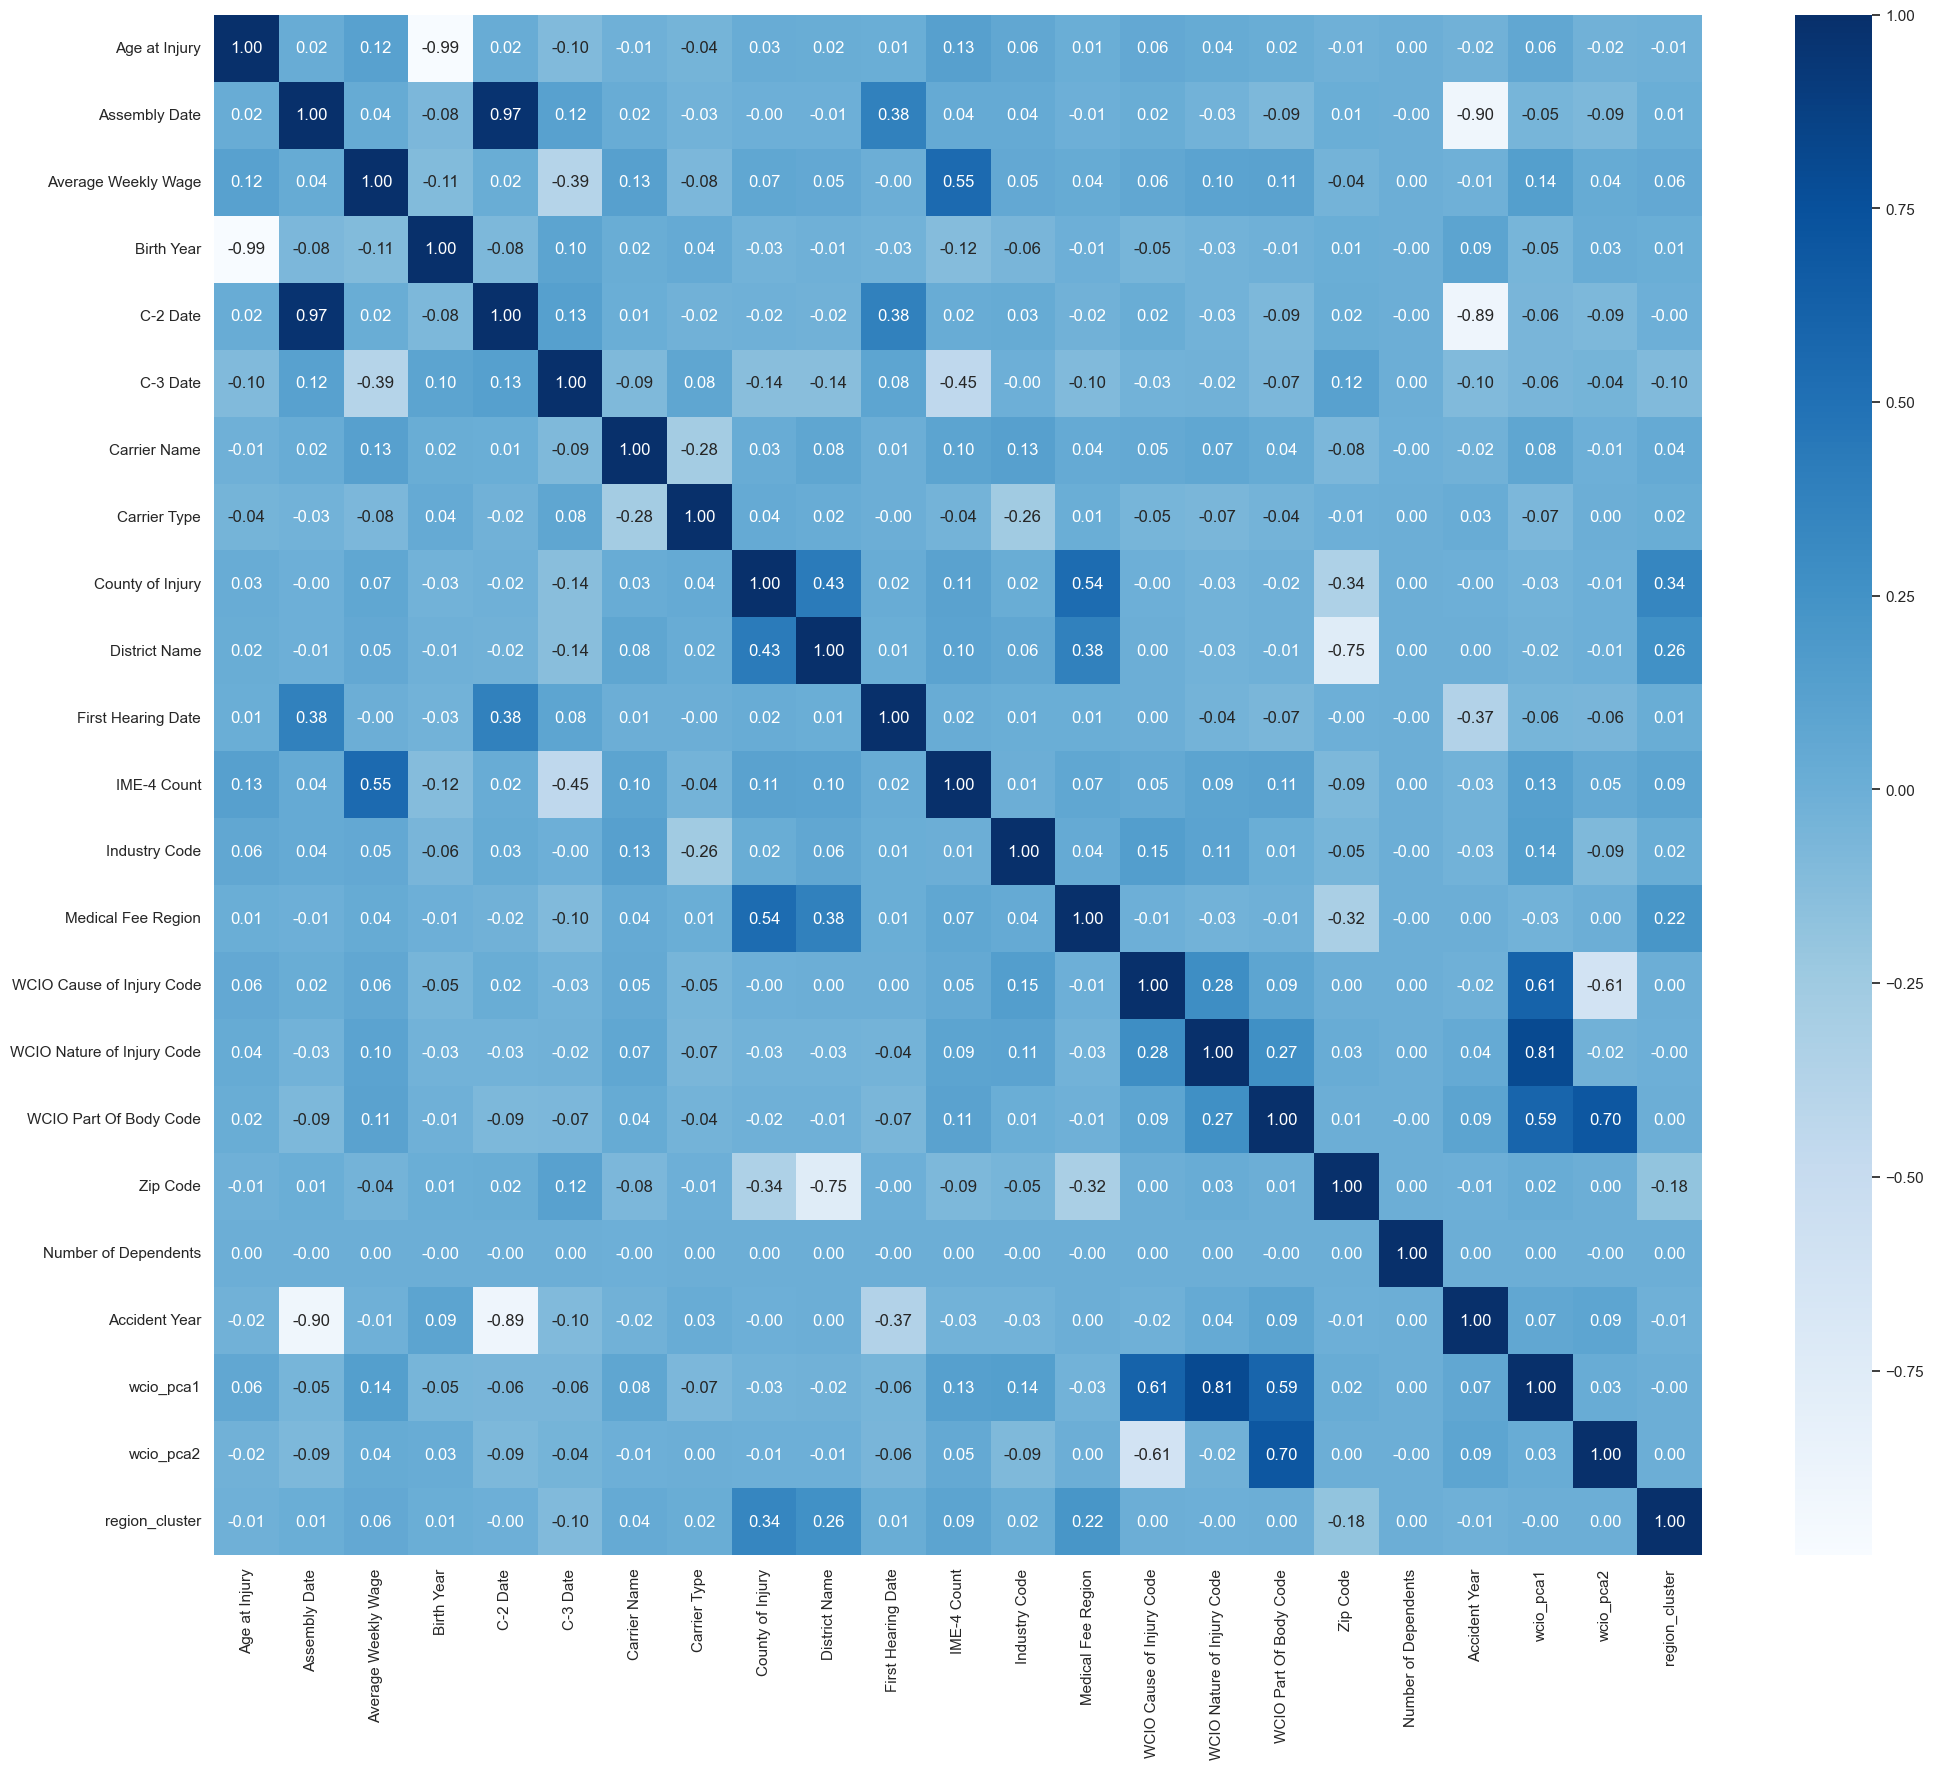

Correlation between Assembly Date and C-2 Date is above 0.8: 0.97
Correlation between C-2 Date and Assembly Date is above 0.8: 0.97
Correlation between WCIO Nature of Injury Code and wcio_pca1 is above 0.8: 0.81
Correlation between wcio_pca1 and WCIO Nature of Injury Code is above 0.8: 0.81


In [39]:
cor_heatmap(cor_spearman)

cor_spearman = continuous_features.corr(method='spearman')

# Filter the correlation matrix
filtered_cor = cor_spearman[
            (cor_spearman > 0.8)
]

# Remove diagonal part
filtered_cor = filtered_cor.mask(np.equal(*np.indices(filtered_cor.shape)))

# Stack the filtered correlation matrix and reset the index
stacked_cor = filtered_cor.stack().reset_index()

# Filter out NaN values and correlations equal to 1
filtered_stacked_cor = stacked_cor[
    stacked_cor[0].notnull() & (stacked_cor[0] != 1)
]

# Print the features and their correlation values with messages
for index, row in filtered_stacked_cor.iterrows():
    feature1 = row['level_0']
    feature2 = row['level_1']
    correlation = row[0]

    if correlation > 0.8:
        print(f"Correlation between {feature1} and {feature2} is above 0.8: {correlation:.2f}")



We will assume that the Thresholds for feature relevance is 0.2 and redundance for 0,8


### Redundancy
drop 'wcio_pca1' or WCIO 'Nature of Injury Code'

drop 'c2 date' or assembly date

drop 'average weekly age or '

### Relevance

Drop Number of depndents




<a class="anchor" id="11th-bullet">

## Wrapper Methods
    
</a>

<a class="anchor" id="12th-bullet">

### RFE
    
</a>

In [46]:
#how many na values are in the dataset
y_preproc_train.isna()

0

<a class="anchor" id="13th-bullet">

#### RFE XGBoosting

</a>

Using RFE, the objective is finding the optimal number of features to select

### RFE XGBoosting

In [ ]:
#number of features
nof_list= np.arange(1, 35)
high_score=0

#Variable to store the optimum features
nof=0
train_f1score_list =[]
val_f1score_list = []

for n in range(len(nof_list)):

    #using XGBoost
    model = XGBClassifier(objective='multi:softprob', random_state=42, learning_rate=0.075, max_depth=12,
    min_child_weight=8, subsample=0.8, colsample_bytree=0.6, n_estimators=2000, reg_alpha=1.0, reg_lambda=1.5
)

    rfe = RFECV(estimator = model,min_features_to_select = nof_list[n], step=1, cv=5)
    X_train_rfe = rfe.fit_transform(X_preproc_train[:500],y_preproc_train[:500])
    X_val_rfe = rfe.transform(X_preproc_val[:500])

    model.fit(X_train_rfe[:500],y_preproc_train[:500])

    # Predictions for F1 score
    y_preproc_train_pred = model.predict(X_train_rfe)
    y_preproc_val_pred = model.predict(X_val_rfe)

    #storing results on training data
    train_f1score = f1_score(y_preproc_train[:500],y_preproc_train_pred[:500], average='macro')
    train_f1score_list.append(train_f1score)

    #storing results on training data
    val_f1score = f1_score(y_preproc_val[:500],y_preproc_val_pred[:500], average='macro')
    val_f1score_list.append(val_f1score)

    #check best score
    if(val_f1score >= high_score):
        high_score = val_f1score
        nof = nof_list[n]
        features_to_select = pd.Series(rfe.support_, index = X_preproc_train.columns)


print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(nof_list, train_f1score_list, label="Train F1 Score")
plt.plot(nof_list, val_f1score_list, label="Validation F1 Score")
plt.xlabel("Number of Features")
plt.ylabel("F1 Score (Macro)")
plt.title("F1 Score vs Number of Features")
plt.legend()
plt.show()

<a class="anchor" id="13th-bullet">

## Embedded Methods
    
</a>

<a class="anchor" id="14th-bullet">

### Lasso Regression
    
</a>

In [65]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [82]:

reg = LassoCV(cv=10, random_state=42)

reg.fit(X_preproc_train, y_preproc_train)

coef = pd.Series(reg.coef_, index = X_preproc_train.columns)
coef

Age at Injury                       0.000000e+00
Assembly Date                       0.000000e+00
Average Weekly Wage                 0.000000e+00
Birth Year                         -0.000000e+00
C-2 Date                            0.000000e+00
C-3 Date                           -0.000000e+00
Carrier Name                        0.000000e+00
Carrier Type                       -0.000000e+00
County of Injury                    4.707993e-06
District Name                      -0.000000e+00
First Hearing Date                  0.000000e+00
IME-4 Count                         0.000000e+00
Industry Code                       0.000000e+00
Medical Fee Region                 -4.222240e-08
WCIO Cause of Injury Code           4.039906e-06
WCIO Nature of Injury Code          2.049125e-06
WCIO Part Of Body Code              8.194614e-06
Zip Code                            4.034321e-06
Agreement Reached                   0.000000e+00
Number of Dependents                0.000000e+00
Accident Year       

In [84]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
#print the features that were eliminated

eliminated_features = coef[coef == 0].index
print(f"Features eliminated: \n{eliminated_features}")

Lasso picked 6 variables and eliminated the other 29 variables


In [85]:

coef.sort_values()

Medical Fee Region                 -4.222240e-08
Age at Injury                       0.000000e+00
Accident Year                      -0.000000e+00
Received_C2                         0.000000e+00
Received_C3                         0.000000e+00
Hearing_held                        0.000000e+00
Attorney/Representative_Y           0.000000e+00
Number of Dependents                0.000000e+00
COVID-19 Indicator_Y               -0.000000e+00
Gender_M                            0.000000e+00
wcio_pca1                           0.000000e+00
wcio_pca2                          -0.000000e+00
region_cluster                      0.000000e+00
high_risk_nature                   -0.000000e+00
high_risk_body                     -0.000000e+00
Alternative Dispute Resolution_Y   -0.000000e+00
Agreement Reached                   0.000000e+00
market_indicator                   -0.000000e+00
Carrier Type                       -0.000000e+00
Assembly Date                       0.000000e+00
Industry Code       

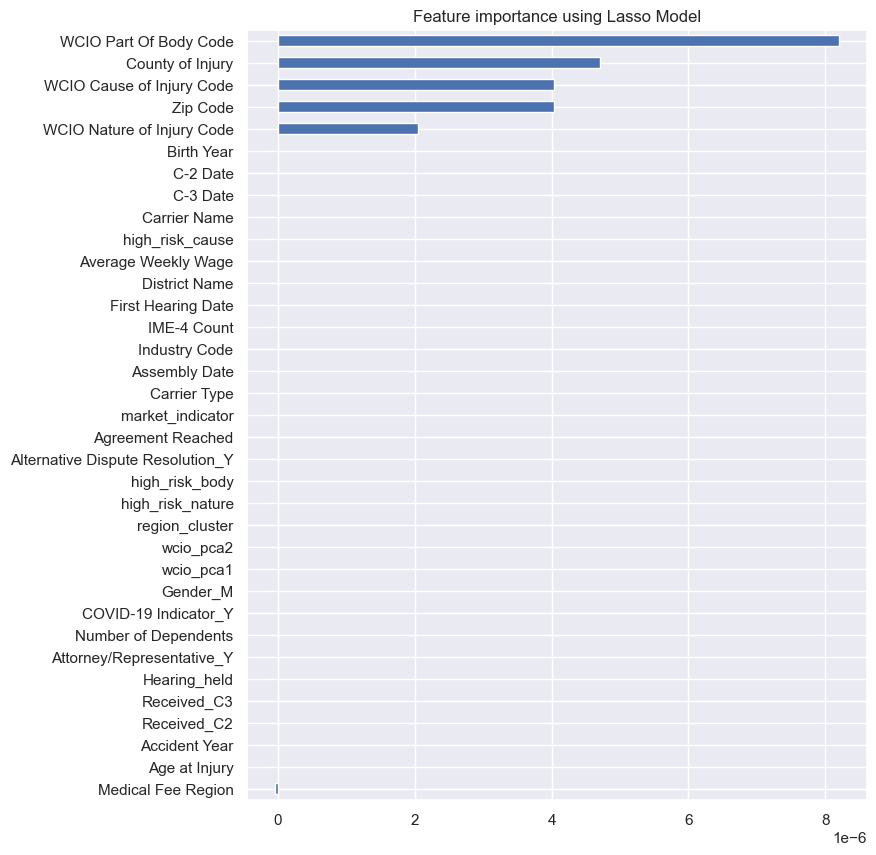

In [86]:
plot_importance(coef,'Lasso')

<a class="anchor" id="15th-bullet">

### Mutual Information Classification
    https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.SelectKBest.html
    https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.mutual_info_regression.html
</a>

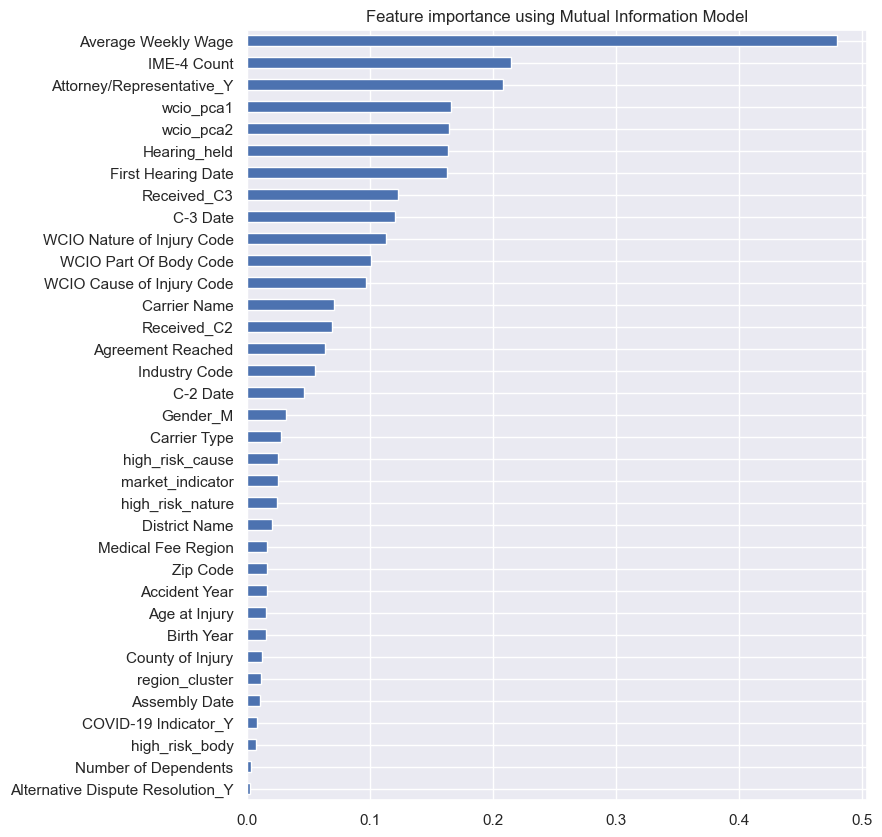

Alternative Dispute Resolution_Y    0.003858
high_risk_body                      0.004270
Number of Dependents                0.004605
COVID-19 Indicator_Y                0.006298
Assembly Date                       0.009172
region_cluster                      0.013115
County of Injury                    0.013515
Birth Year                          0.014163
Accident Year                       0.014745
Zip Code                            0.016299
Age at Injury                       0.017122
Medical Fee Region                  0.017275
District Name                       0.019712
market_indicator                    0.023039
high_risk_nature                    0.023708
high_risk_cause                     0.025922
Carrier Type                        0.027137
Gender_M                            0.034372
C-2 Date                            0.045771
Industry Code                       0.054329
Agreement Reached                   0.063949
Received_C2                         0.068997
Carrier Na

In [88]:
#  Mutual Information Regression for feature selection in regression problems
mic = SelectKBest(score_func= mutual_info_classif, k= 'all')

# fit the model to the training data
mic.fit(X_preproc_train, y_preproc_train)

# get the scores of the features
mic_scores = pd.Series(mic.scores_, index = X_preproc_train.columns)

# plot the scores
plot_importance(mic_scores,'Mutual Information')
mic_scores.sort_values()

#print the features that were eliminated

eliminated_features = mic_scores[mic_scores <= 0.0285].index

print(f"Features to be eliminated: \n{eliminated_features}")

Use everything above Gneder_m

<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>

### Numerical Data

| Predictor | Unvariate|  Spearman | Variance information factor (VIF)| (IG)Information Gain | Feature Imprtance XGB (SHAP)| RFE XGB | Lasso | Mutual Information Class. | What to do? |
| --- | --- | --- | --- |--- |---|---|---|---| ---|
| Age at Injury | Keep | --- | --- |--- |---|---|---|---| ---|
| Assembly Date | Keep | --- | --- |--- |---|---|---|---| ---|
| Average Weekly Wage | Keep | --- | --- |--- |---|---|---|---| ---|
| Birth Year | Keep | --- | --- |--- |---|---|---|---| ---|
| C-2 Date | Keep | --- | --- |--- |---|---|---|---| ---|
| C-3 Date | Keep | --- | --- |--- |---|---|---|---| ---|
| Carrier Name | Keep | --- | --- |--- |---|---|---|---| ---|
| Carrier Type | Keep | --- | --- |--- |---|---|---|---| ---|
| County of Injury | Keep | --- | --- |--- |---|---|---|---| ---|
| District Name | Keep | --- | --- |--- |---|---|---|---| ---|
| First Hearing Date | Keep | --- | --- |--- |---|---|---|---| ---|
| IME-4 Count | Keep | --- | --- |--- |---|---|---|---| ---|
| Industry Code | Keep | --- | --- |--- |---|---|---|---| ---|
| Medical Fee Region | Keep | --- | --- |--- |---|---|---|---| ---|
| WCIO Cause of Injury Code | Keep | --- | --- |--- |---|---|---|---| ---|
| WCIO Nature of Injury Code | Keep | --- | --- |--- |---|---|---|---| ---|
| WCIO Part Of Body Code | Keep | --- | --- |--- |---|---|---|---| ---|
| Zip Code | Keep | --- | --- |--- |---|---|---|---| ---|
| Agreement Reached | Keep | --- | --- |--- |---|---|---|---| ---|
| Number of Dependents | Keep | --- | --- |--- |---|---|---|---| ---|
| Accident Year | Keep | --- | --- |--- |---|---|---|---| ---|
| Received_C2 | Keep | --- | --- |--- |---|---|---|---| ---|
| Received_C3 | Keep | --- | --- |--- |---|---|---|---| ---|
| Hearing_held | Keep | --- | --- |--- |---|---|---|---| ---|
| Attorney/Representative_Y | Keep | --- | --- |--- |---|---|---|---| ---|
| COVID-19 Indicator_Y | Keep | --- | --- |--- |---|---|---|---| ---|
| Alternative Dispute Resolution_Y | Keep | --- | --- |--- |---|---|---|---| ---|
| Gender_M | Keep | --- | --- |--- |---|---|---|---| ---|
| wcio_pca1 | Keep | --- | --- |--- |---|---|---|---| ---|
| wcio_pca2 | Keep | --- | --- |--- |---|---|---|---| ---|
| region_cluster | Keep | --- | --- |--- |---|---|---|---| ---|
| high_risk_nature | Keep | --- | --- |--- |---|---|---|---| ---|
| high_risk_body | Keep | --- | --- |--- |---|---|---|---| ---|
| high_risk_cause | Keep | --- | --- |--- |---|---|---|---| ---|
| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|

<hr>


